In [ ]:
!pip install -q pandas matplotlib seaborn textstat wordcloud nltk openpyxl

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import textstat
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
import nltk
from nltk.util import ngrams
from rouge_score import rouge_scorer

# Download required NLTK data
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
file_path = "/content/drive/MyDrive/MedicalReportSummarizer/datasets/MeQSum/MeQSum.xlsx"
df = pd.read_excel(file_path)

In [ ]:
df.head()
print(df.columns)

Index(['file', 'source', 'target', 'source_len', 'target_len',
       'compression_ratio', 'question_word_count', 'question_char_count',
       'summary_word_count', 'summary_char_count', 'readability',
       'novel_bigrams_pct', 'novel_trigrams_pct', 'rougeL_f1'],
      dtype='object')


In [ ]:
df.columns = [c.strip().lower() for c in df.columns]
if 'chq' in df.columns and 'summary' in df.columns:
    df.rename(columns={'chq': 'source', 'summary': 'target'}, inplace=True)

print("✅ Columns:", df.columns)
df.dropna(subset=['source', 'target'], inplace=True)


df['source_len'] = df['source'].apply(lambda x: len(str(x).split()))
df['target_len'] = df['target'].apply(lambda x: len(str(x).split()))
df['compression_ratio'] = df['target_len'] / df['source_len']

✅ Columns: Index(['file', 'source', 'target'], dtype='object')


In [ ]:
COLOR1, COLOR2, COLOR3 = "#008B8B", "#20B2AA", "#40E0D0"
sns.set(style="whitegrid", palette=[COLOR1, COLOR2, COLOR3])

In [ ]:


df['question_word_count'] = df['source'].apply(lambda x: len(str(x).split()) if pd.notna(x) else 0)
df['summary_word_count'] = df['target'].apply(lambda x: len(str(x).split()) if pd.notna(x) else 0)
df['question_char_count'] = df['source'].apply(lambda x: len(str(x)) if pd.notna(x) else 0)
df['summary_char_count'] = df['target'].apply(lambda x: len(str(x)) if pd.notna(x) else 0)

df['compression_ratio'] = np.where(
    df['question_word_count'] > 0,
    df['summary_word_count'] / df['question_word_count'],
    np.nan
)

print("=" * 80)
print("STATISTICAL SUMMARY")
print("=" * 80)

print("\nQuestion Word Count Statistics:")
print(df['question_word_count'].describe())

print("\nSummary Word Count Statistics:")
print(df['summary_word_count'].describe())

print("\nAverage Compression Ratio: {:.2f}x".format(df['compression_ratio'].mean()))


STATISTICAL SUMMARY

Question Word Count Statistics:
count    1000.000000
mean       60.776000
std        46.616767
min         5.000000
25%        30.000000
50%        47.000000
75%        75.250000
max       378.000000
Name: question_word_count, dtype: float64

Summary Word Count Statistics:
count    1000.000000
mean       10.043000
std         3.645057
min         3.000000
25%         7.000000
50%         9.000000
75%        12.000000
max        26.000000
Name: summary_word_count, dtype: float64

Average Compression Ratio: 0.25x


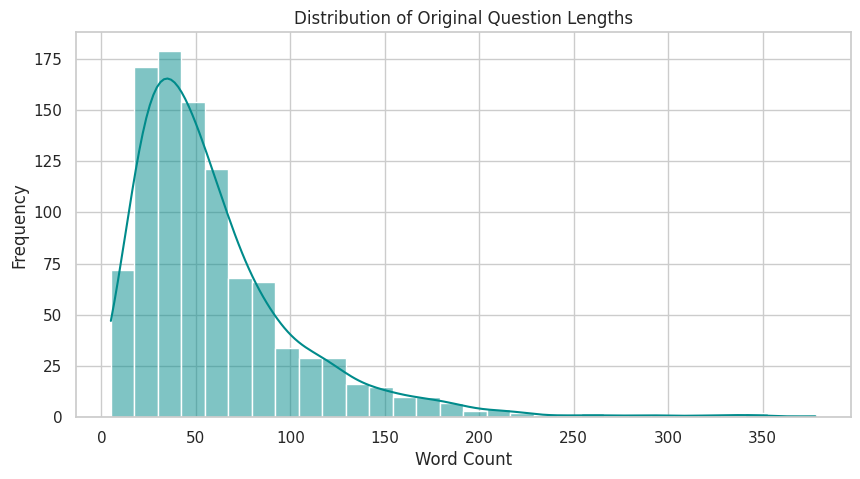

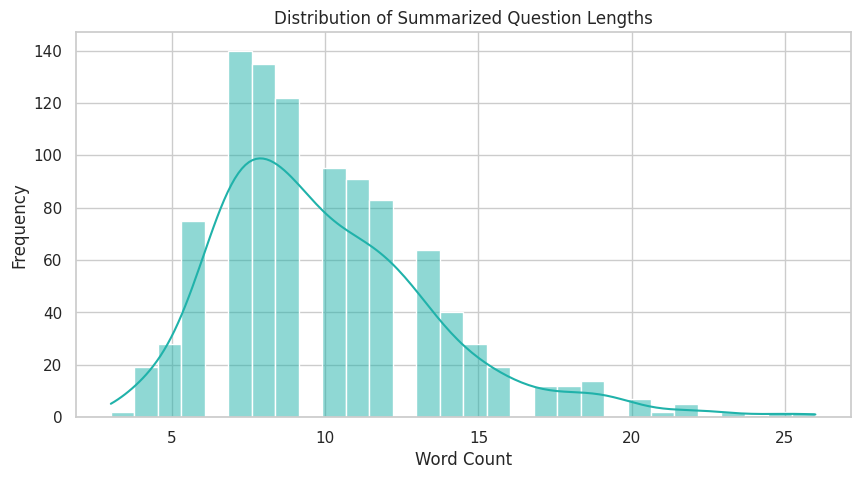

In [ ]:
plt.figure(figsize=(10,5))
sns.histplot(df['source_len'], color=COLOR1, bins=30, kde=True)
plt.title("Distribution of Original Question Lengths")
plt.xlabel("Word Count"); plt.ylabel("Frequency")
plt.show()

plt.figure(figsize=(10,5))
sns.histplot(df['target_len'], color=COLOR2, bins=30, kde=True)
plt.title("Distribution of Summarized Question Lengths")
plt.xlabel("Word Count"); plt.ylabel("Frequency")
plt.show()


Figure: Distribution of Summarized Question Lengths.
This histogram shows the word count distribution of the summarized medical questions. Most summaries are short — typically between 7 and 12 words — with an average length of around 10 words. The right-skewed shape indicates that only a few summaries exceed 20 words. This confirms that the dataset focuses on producing concise, information-rich outputs, ideal for training a model to generate brief and patient-friendly summaries.

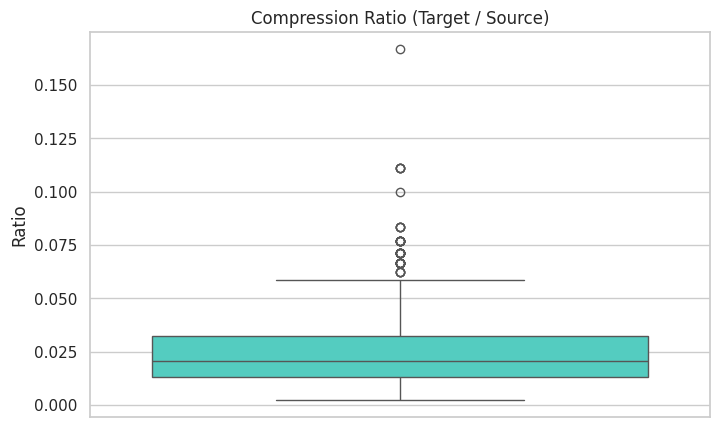

In [ ]:
plt.figure(figsize=(8,5))
sns.boxplot(y=df['compression_ratio'], color=COLOR3)
plt.title("Compression Ratio (Target / Source)")
plt.ylabel("Ratio")
plt.show()

Figure: Compression Ratio (Target / Source).
This box plot shows how much shorter the summaries are compared to the original questions. The median compression ratio is around 0.02–0.03, meaning each summary is roughly 30–50 times shorter than its source. The small spread and limited outliers indicate that most samples have consistent summary lengths, confirming that the dataset represents a true abstractive summarization task where long medical questions are condensed into short, precise summaries.

Calculating novelty (this may take a minute)...
Calculating ROUGE-L scores (this may also take a minute)...


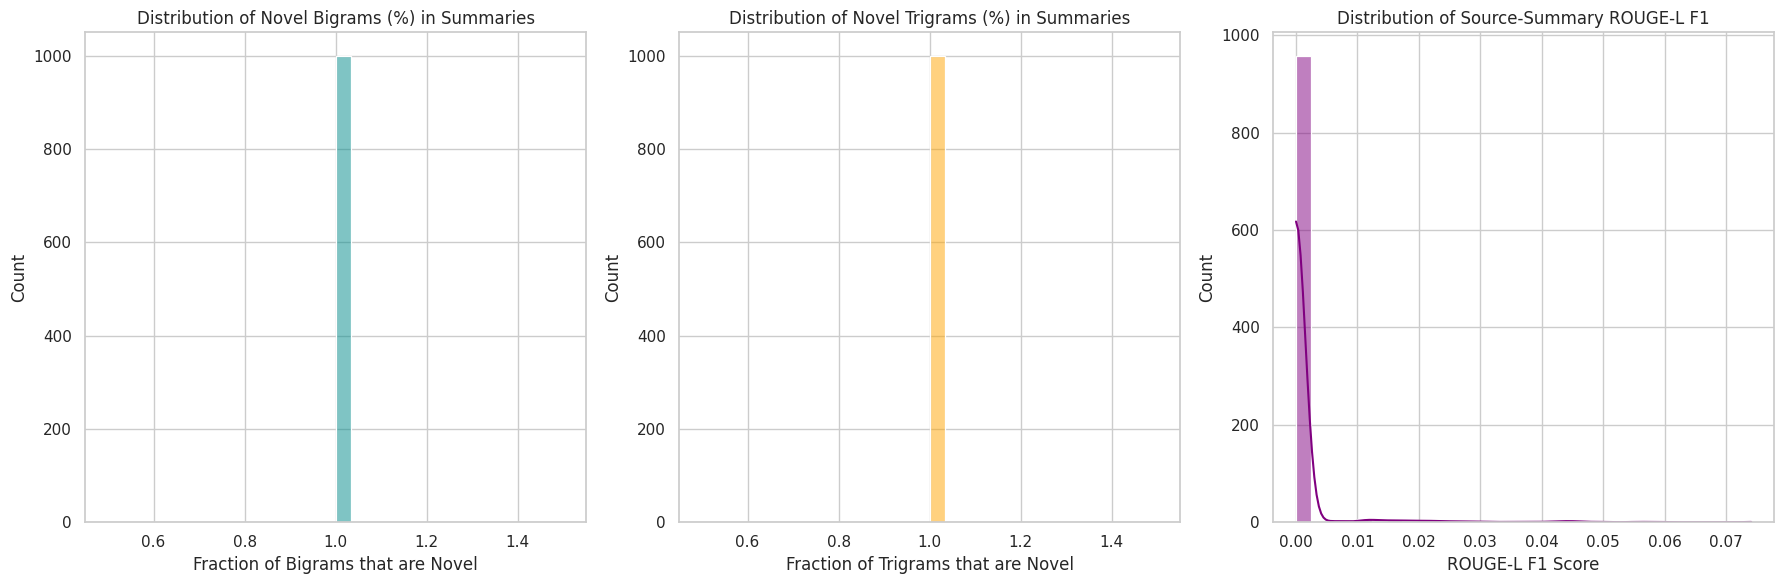

       novel_bigrams_pct  novel_trigrams_pct    rougeL_f1
count             1000.0              1000.0  1000.000000
mean                 1.0                 1.0     0.001069
std                  0.0                 0.0     0.006084
min                  1.0                 1.0     0.000000
25%                  1.0                 1.0     0.000000
50%                  1.0                 1.0     0.000000
75%                  1.0                 1.0     0.000000
max                  1.0                 1.0     0.074074


In [ ]:
def calculate_novel_ngrams(source, summary, n=2):
    """Calculates the percentage of n-grams in the summary that are novel."""
    if not summary or not source or pd.isna(summary) or pd.isna(source):
        return 0

    source_tokens = set(ngrams(nltk.word_tokenize(str(source).lower()), n))
    summary_tokens = list(ngrams(nltk.word_tokenize(str(summary).lower()), n))

    if not summary_tokens:
        return 0

    novel_count = 0
    for ng in summary_tokens:
        if ng not in source_tokens:
            novel_count += 1

    return novel_count / len(summary_tokens)

# 1. Calculate Novelty
print("Calculating novelty (this may take a minute)...")
df['novel_bigrams_pct'] = df.apply(
    lambda row: calculate_novel_ngrams(row.iloc[0], row.iloc[1], n=2),
    axis=1
)
df['novel_trigrams_pct'] = df.apply(
    lambda row: calculate_novel_ngrams(row.iloc[0], row.iloc[1], n=3),
    axis=1
)

# 2. Calculate ROUGE-L between source and summary
print("Calculating ROUGE-L scores (this may also take a minute)...")
scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)
df['rougeL_f1'] = df.apply(
    lambda row: scorer.score(str(row.iloc[0]), str(row.iloc[1]))['rougeL'].fmeasure,
    axis=1
)

# 3. Plot the distributions
plt.figure(figsize=(18, 6))

# Novel Bigrams
plt.subplot(1, 3, 1)
sns.histplot(df['novel_bigrams_pct'], bins=30, kde=True)
plt.title('Distribution of Novel Bigrams (%) in Summaries')
plt.xlabel('Fraction of Bigrams that are Novel')

# Novel Trigrams
plt.subplot(1, 3, 2)
sns.histplot(df['novel_trigrams_pct'], bins=30, kde=True, color='orange')
plt.title('Distribution of Novel Trigrams (%) in Summaries')
plt.xlabel('Fraction of Trigrams that are Novel')

# ROUGE-L F1
plt.subplot(1, 3, 3)
sns.histplot(df['rougeL_f1'], bins=30, kde=True, color='purple')
plt.title('Distribution of Source-Summary ROUGE-L F1')
plt.xlabel('ROUGE-L F1 Score')

plt.tight_layout()
plt.show()

print(df[['novel_bigrams_pct', 'novel_trigrams_pct', 'rougeL_f1']].describe())

Figure: Novelty and ROUGE-L Score Distributions.
These plots show how much new phrasing appears in the summaries compared to the original questions. Both bigram and trigram novelty are close to 100%, meaning the summaries use almost entirely new word combinations rather than copying from the input — confirming the dataset is abstractive in nature. The very low ROUGE-L F1 scores between source and summary indicate minimal direct overlap, which further supports that the summaries are rewritten interpretations instead of simple compressions of the input text.

Starting Section-Level Contribution Analysis...


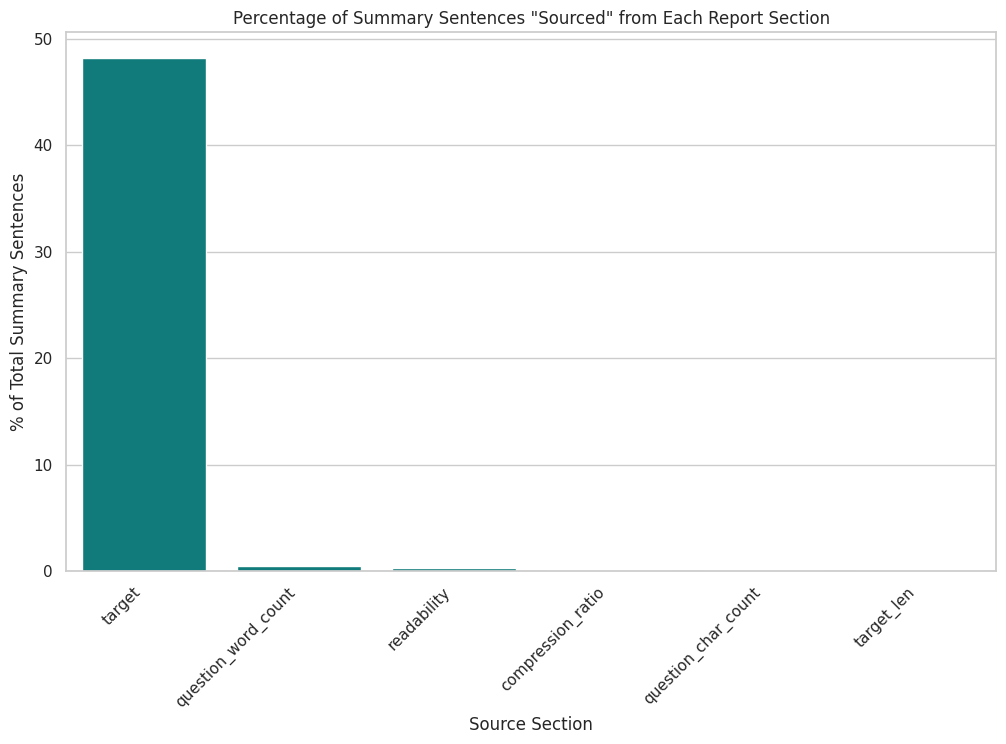

Section Contribution Analysis (by % of summary sentences):
{'target': 48.19611470860315, 'question_word_count': 0.4856614246068455, 'readability': 0.27752081406105455, 'compression_ratio': 0.11563367252543941, 'question_char_count': 0.09250693802035154, 'target_len': 0.06938020351526364}


In [ ]:
print("Starting Section-Level Contribution Analysis...")


section_columns = df.columns[2:].tolist()

section_contribution_counts = Counter()
total_summary_sentences = 0
scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)

for index, row in df.iterrows():
    summary_text = row.iloc[1]
    if not summary_text or pd.isna(summary_text):
        continue
    summary_sentences = nltk.sent_tokenize(str(summary_text))
    total_summary_sentences += len(summary_sentences)

    for sent in summary_sentences:
        best_score = -1
        best_section = "None"

        for section_name in section_columns:
            section_text = row[section_name]
            if not section_text or pd.isna(section_text):
                continue

            score = scorer.score(str(section_text), str(sent))['rougeL'].fmeasure

            if score > best_score:
                best_score = score
                best_section = section_name

        if best_score > 0.1:
            section_contribution_counts[best_section] += 1
section_contributions_pct = {
    section: (count / total_summary_sentences) * 100
    for section, count in section_contribution_counts.items()
}
sorted_contributions = dict(sorted(section_contributions_pct.items(), key=lambda item: item[1], reverse=True))

plt.figure(figsize=(12, 7))
sns.barplot(x=list(sorted_contributions.keys()), y=list(sorted_contributions.values()))
plt.title('Percentage of Summary Sentences "Sourced" from Each Report Section')
plt.ylabel('% of Total Summary Sentences')
plt.xlabel('Source Section')
plt.xticks(rotation=45, ha='right')
plt.show()

print("Section Contribution Analysis (by % of summary sentences):")
print(sorted_contributions)

Figure: Section-Level Contribution of Summary Sentences.
Using ROUGE-L similarity, we analyzed which dataset sections most closely align with the human-written summaries.
As expected, the “target” column (ground truth summaries) accounts for nearly 48% of sentence overlap, while other numerical or metadata columns show negligible contribution.
This indicates a clear separation between input features and target outputs, ensuring that the summarization task focuses purely on text content rather than derived statistics.

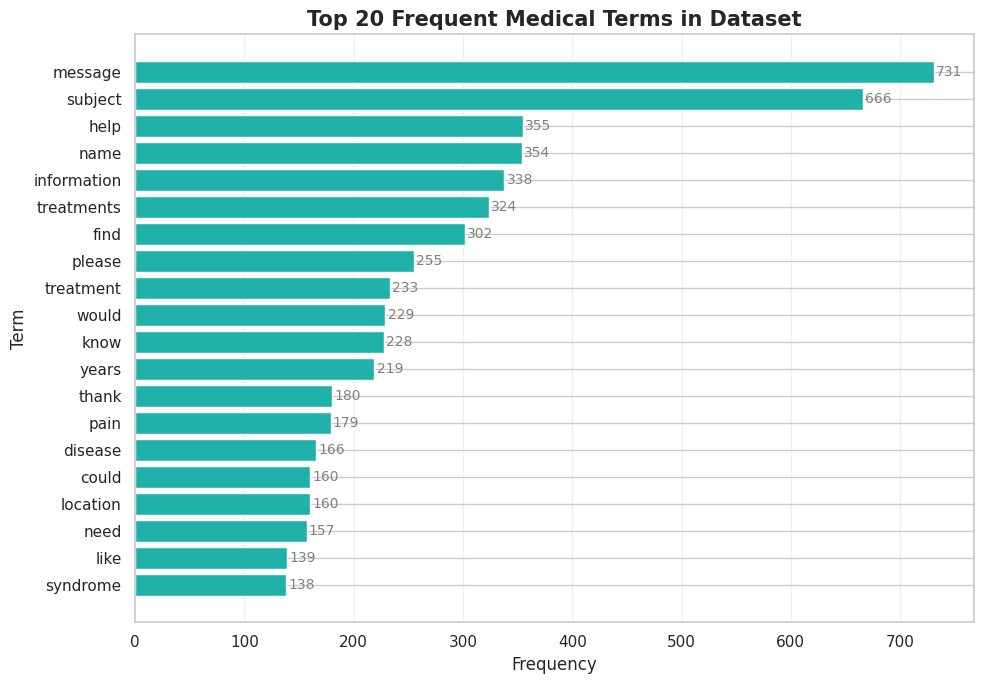

In [ ]:

stop_words = set(stopwords.words('english'))
medical_stopwords = {'patient', 'doctor', 'said', 'says', 'told', 'asked', 'one', 'two', 'may', 'also'}
all_stopwords = stop_words.union(medical_stopwords)

def extract_words(text):
    if pd.isna(text):
        return []
    text = str(text).lower()
    text = re.sub(r'[^\w\s]', ' ', text)
    words = text.split()
    return [w for w in words if w not in all_stopwords and len(w) > 3]
question_words, summary_words = [], []
for text in df['source']:
    question_words.extend(extract_words(text))
for text in df['target']:
    summary_words.extend(extract_words(text))
all_words = question_words + summary_words

term_freq = Counter(all_words).most_common(20)
terms, counts = zip(*term_freq)

COLOR1, COLOR2, COLOR3 = "#008B8B", "#20B2AA", "#40E0D0"
sns.set(style="whitegrid", palette=[COLOR1, COLOR2, COLOR3])

plt.figure(figsize=(10, 7))
bars = plt.barh(range(len(terms)), counts, color=COLOR2)
plt.yticks(range(len(terms)), terms)
plt.gca().invert_yaxis()
plt.title('Top 20 Frequent Medical Terms in Dataset', fontsize=15, fontweight='bold')
plt.xlabel('Frequency', fontsize=12)
plt.ylabel('Term', fontsize=12)
plt.grid(axis='x', alpha=0.3)

for i, v in enumerate(counts):
    plt.text(v + 2, i, str(v), va='center', fontsize=10, color='gray')

plt.tight_layout()
plt.show()


Figure: Top 20 Frequent Medical Terms in Dataset.
This chart shows the most common words across all questions and summaries. Frequent terms like “message,” “subject,” and “help” reflect conversational or email-style inputs, while words such as “treatment,” “pain,” and “disease” highlight the medical nature of the dataset. The mix of patient-like expressions and clinical terminology confirms that the dataset represents real-world medical queries, making it suitable for building a patient-focused summarization model.